# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG) and bined color features exploration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
import time

%matplotlib inline

test_image='./test_images/test1.jpg'

C:\Users\eduardo\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Draw boxes method used to draw boxes in the image

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img

Color histogram function this function creates a histogram of color from a given image

In [3]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Quick visualization of the histograms created with the previous function

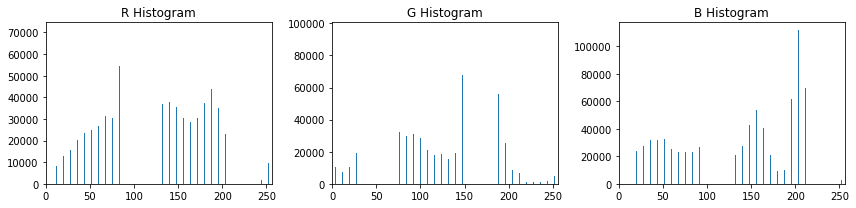

In [4]:
image = mpimg.imread(test_image)
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

# Color spaces exploration

Here I plot each channel from different color spaces, in the hope of visualizing which color space makes car features pop out from the rest of the picture, I think YUV and YCrCb colors spaces are promissing ones

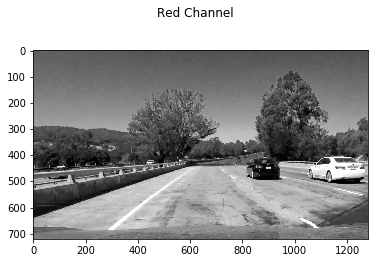

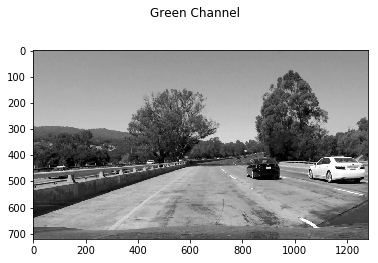

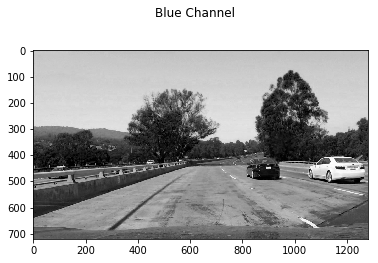

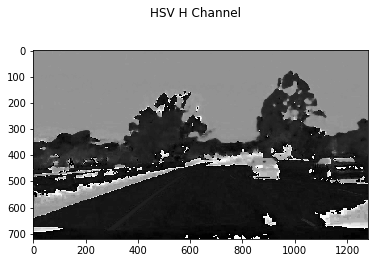

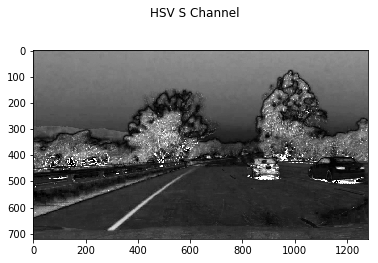

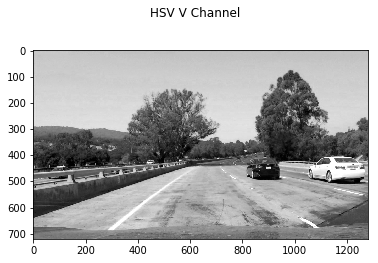

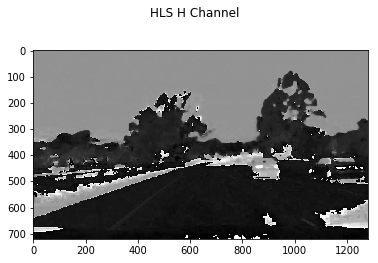

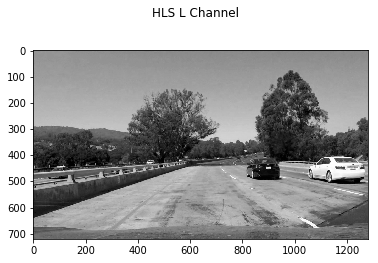

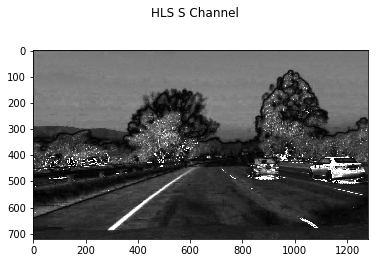

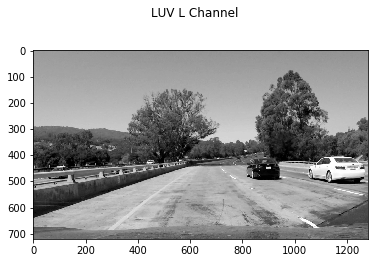

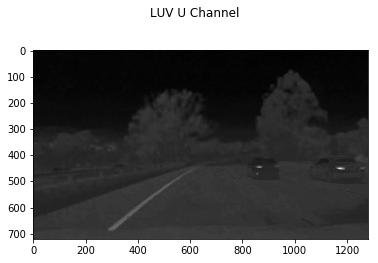

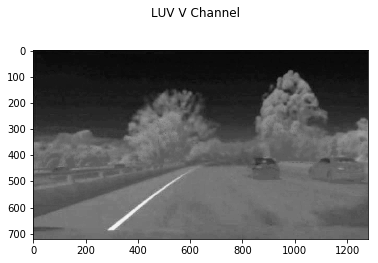

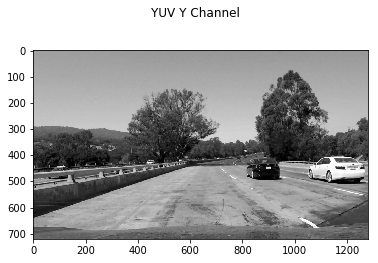

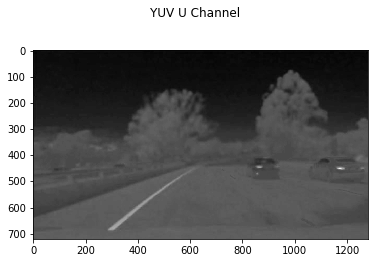

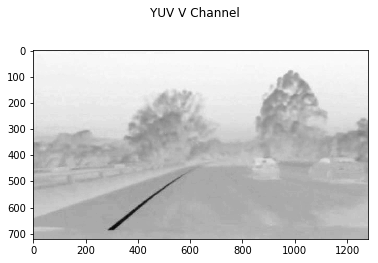

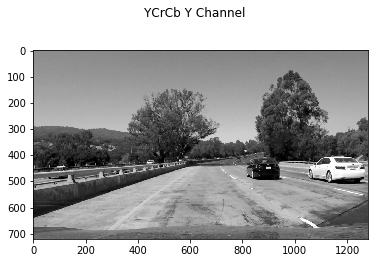

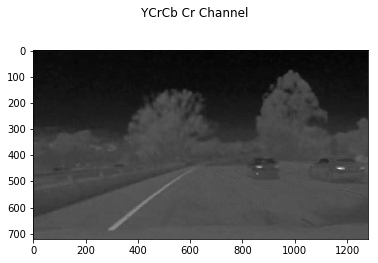

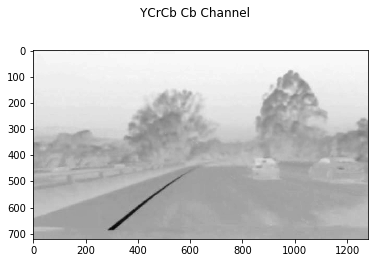

In [5]:

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

A = image[:,:,0]
B = image[:,:,1]
C = image[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("Red Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("Green Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("Blue Channel")

A = hsv[:,:,0]
B = hsv[:,:,1]
C = hsv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("HSV H Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("HSV S Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("HSV V Channel")

A = hls[:,:,0]
B = hls[:,:,1]
C = hls[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("HLS H Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("HLS L Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("HLS S Channel")

A = luv[:,:,0]
B = luv[:,:,1]
C = luv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("LUV L Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("LUV U Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("LUV V Channel")

A = yuv[:,:,0]
B = yuv[:,:,1]
C = yuv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("YUV Y Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("YUV U Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("YUV V Channel")

A = ycrcb[:,:,0]
B = ycrcb[:,:,1]
C = ycrcb[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("YCrCb Y Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("YCrCb Cr Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("YCrCb Cb Channel")

In [6]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

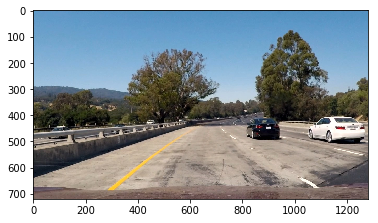

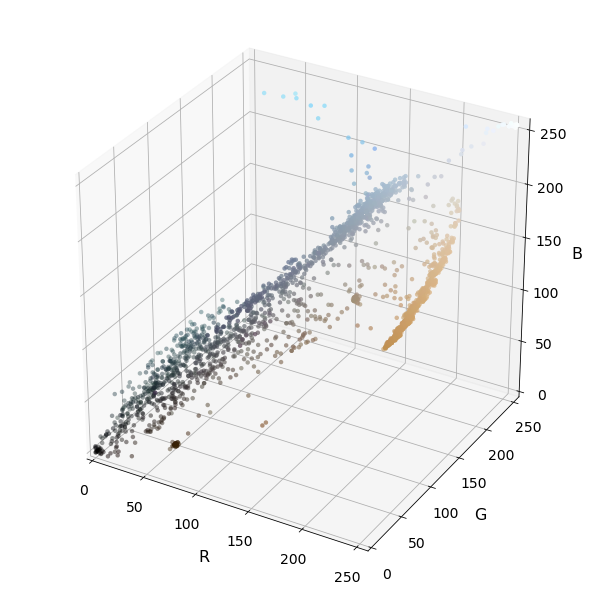

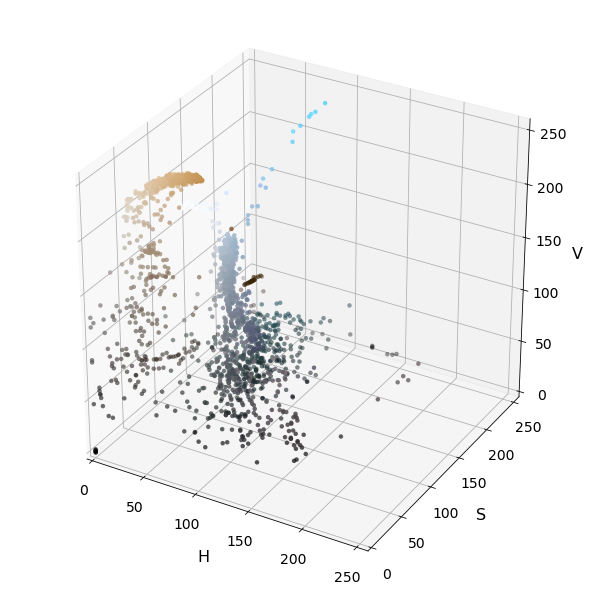

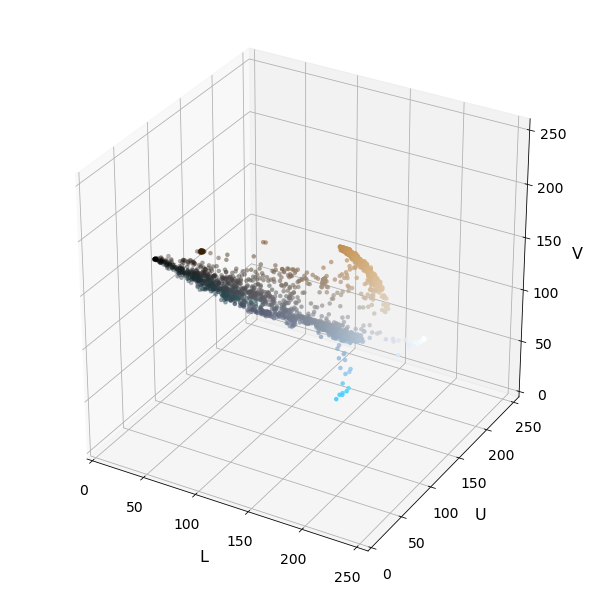

In [7]:
img = mpimg.imread(test_image)

plt.figure()
plt.imshow(img)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)



img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

Here I redefine the bin_spatial method to account for color spaces

In [8]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features

In [9]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

1196
1125
Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


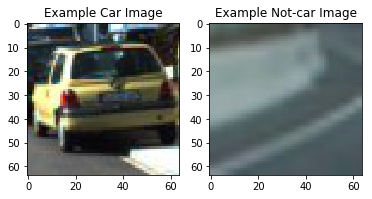

In [10]:
cars = glob.glob('./datasets/vehicles_smallset/*/*.jpeg')
notcars = glob.glob('./datasets/non-vehicles_smallset/*/*.jpeg')

print(len(cars))
print(len(notcars))

data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

Here I define the extract hog features method.

In [11]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

Now I load an image to test the hog extraction method and I verify how it will look like, I also tuned the varibles (orient, pix_per_cell, cell_per_block) to get what think would be a useful feature 

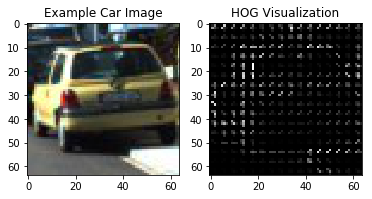

In [12]:
# Read in the image
image = mpimg.imread(cars[car_ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 4
cell_per_block = 8
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

Now I prepare two feature extraction methods just so I can test them separately 

In [22]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Train a classifier

Here I previously loaded a dataset composed of a subset of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).

Below I extarct and scale the features and I create two SVM classifiers one for each feature so I can compare their effectiviness

By far the classifier feed with hog features is the best and that's what I decide to use to classify cars.

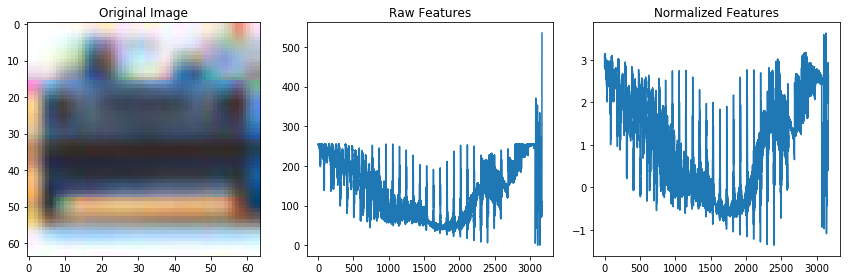

In [14]:
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_spatial_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_spatial_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [15]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc_spatial = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc_spatial.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_spatial.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc_spatial.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9849
My SVC predicts:  [ 0.  1.  0.  1.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  1.  1.  1.  1.  1.]
0.006 Seconds to predict 10 labels with SVC


In [16]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 4
cell_per_block = 8
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_hog_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_hog_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
hog_X = np.vstack((car_hog_features, notcar_hog_features)).astype(np.float64)                        
# Fit a per-column scaler
X_hog_scaler = StandardScaler().fit(hog_X)
# Apply the scaler to X
scaled_hog_X = X_hog_scaler.transform(hog_X)

# Define the labels vector
y = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(notcar_hog_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(
    scaled_hog_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_hog_train[0]))
# Use a linear SVC 
svc_hog = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc_hog.fit(X_hog_train, y_hog_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_hog.score(X_hog_test, y_hog_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc_hog.predict(X_hog_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_hog_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

16.02 Seconds to extract HOG features...
Using: 8 orientations 4 pixels per cell and 8 cells per block
Feature vector length: 124416
7.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  0.  1.  0.  1.]
0.005 Seconds to predict 10 labels with SVC


# Sliding window

In [17]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


224


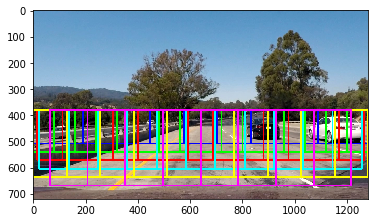

In [18]:
image = mpimg.imread(test_image)
initial_size = 128
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))
initial_size += 32
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))

initial_size += 32
windows3 = slide_window(image, x_start_stop=[16, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))

initial_size += 32
print(initial_size)
windows4 = slide_window(image, x_start_stop=[24, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))

initial_size += 32
windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))

initial_size += 32
windows6 = slide_window(image, x_start_stop=[64, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))
                       
windows = []
windows.append(windows1)
windows.append(windows2)
windows.append(windows3)
windows.append(windows4)
windows.append(windows5)
windows.append(windows6)

image = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
image = draw_boxes(image, windows2, color=(0, 255, 0), thick=6)
image = draw_boxes(image, windows3, color=(255, 0, 0), thick=6)
image = draw_boxes(image, windows4, color=(0, 255, 255), thick=6)
image = draw_boxes(image, windows5, color=(255, 255, 0), thick=6)
image = draw_boxes(image, windows6, color=(255, 0, 255), thick=6)
plt.imshow(image)

In [19]:
def extract_hog_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
    # Return list of feature vectors
    return features

In [20]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows lists in the list
    index =0
    for window_list in windows:
        for window in window_list:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            mpimg.imsave('./output_images/{}.jpg'.format(index),test_img)
            index += 1
            #4) Extract features for that window using extract_hog_features()
            features = extract_hog_features(test_img, cspace=color_space, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

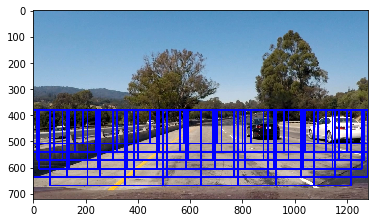

In [21]:
image = mpimg.imread(test_image)

color_space = 'YCrCb'
orient = 8
pix_per_cell = 4
cell_per_block = 8
hog_channel = "ALL"

detections = search_windows(image, windows, svc_hog, X_hog_scaler, color_space=color_space, 
               orient=orient, pix_per_cell=pix_per_cell, 
               cell_per_block=cell_per_block, hog_channel=hog_channel)

image = draw_boxes(image, detections, color=(0, 0, 255), thick=6)
    
plt.imshow(image)